## Unsupervised final assignment

* Data: primates-morphology.csv

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import plotly.express as px
from sklearn.decomposition import PCA

In [22]:
data = pd.read_csv("./Data/primates-morphology.csv")
df = data.copy()
df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,25,26,27,28,29,Abbreviation,Genus,Species,Sex,Age
0,37773,133.426742,-101.627603,21.125902,-11.518251,4.621089,-1.519551,0.583410,-7.182875,1.410030,...,-0.301822,-0.433051,0.037651,-0.279618,-0.421040,Ph,Presbytis,hosei,U,A
1,37772,145.344740,-108.229812,21.121390,-14.982879,2.299335,-2.354040,0.431199,-5.266930,-1.424469,...,0.215340,-0.299550,0.709472,0.876382,-0.150133,Ph,Presbytis,hosei,F,A
2,22276,137.773342,-107.162743,18.232497,-17.116294,3.016809,-5.295234,1.716895,-1.668914,-1.917478,...,-0.481468,-0.243025,-0.537644,-0.140292,0.082158,Pr,Presbytis,rubicunda,U,A
3,37776,141.523739,-107.436626,17.448083,-16.861469,3.382894,-1.071286,1.768891,-2.735232,-1.136700,...,0.586941,-0.043639,-0.518699,-1.051100,0.542354,Pr,Presbytis,rubicunda,M,A
4,37777,142.357906,-97.195294,10.511391,-6.520641,3.555506,1.652390,-0.655919,-5.373075,-1.466841,...,0.653851,0.718319,0.798722,-0.396749,0.844772,Pr,Presbytis,rubicunda,F,A


### Inspecting the data
Data is already in coordinates

Check for missing data, skewness, distribution, sample, linearity, correlations etc.

In [23]:
df.info()
na_count = df.isna().sum().sum()
features = list(df.columns[1:31])
X = df[features]

print(f'Empty value count: {na_count}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 36 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    165 non-null    int64  
 1   0             165 non-null    float64
 2   1             165 non-null    float64
 3   2             165 non-null    float64
 4   3             165 non-null    float64
 5   4             165 non-null    float64
 6   5             165 non-null    float64
 7   6             165 non-null    float64
 8   7             165 non-null    float64
 9   8             165 non-null    float64
 10  9             165 non-null    float64
 11  10            165 non-null    float64
 12  11            165 non-null    float64
 13  12            165 non-null    float64
 14  13            165 non-null    float64
 15  14            165 non-null    float64
 16  15            165 non-null    float64
 17  16            165 non-null    float64
 18  17            165 non-null    

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,27,28,29
count,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,...,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000
mean,32304.406061,5.537129,1.196007,-0.125596,0.774423,-0.161111,-0.182550,-0.077955,0.180683,0.132617,...,0.057334,-0.014223,0.013269,-0.002892,0.005006,0.003208,-0.001137,-0.002748,-0.012738,-0.013131
std,10702.789245,99.061556,69.971050,56.627559,18.591984,11.336600,8.710069,5.463093,5.214248,4.520787,...,1.254471,1.161247,0.971599,0.932425,0.865874,0.750532,0.720479,0.484438,0.461879,0.374258
min,5547.000000,-201.591249,-111.659165,-114.986835,-54.636918,-19.375303,-24.431319,-54.611282,-20.855026,-18.487708,...,-3.793245,-2.894577,-3.849517,-1.838070,-2.274559,-2.037714,-2.934118,-1.245955,-2.115305,-1.128128
25%,23812.000000,-58.767559,-44.542377,-45.981261,-12.328664,-7.348686,-5.823589,-1.389680,-2.572926,-2.279476,...,-0.697783,-0.739499,-0.482541,-0.585089,-0.587203,-0.413921,-0.411248,-0.300449,-0.320591,-0.248282
50%,35640.000000,-4.994670,18.343281,-2.090244,4.082730,-2.158090,-1.071286,-0.124301,-0.379776,-0.057433,...,0.086293,-0.103932,0.123128,-0.072030,-0.018886,-0.023107,-0.022457,0.001251,-0.018000,-0.010527
75%,39390.000000,89.480991,42.633134,32.805157,16.969797,3.716401,5.078963,1.575336,3.017432,3.199454,...,0.784991,0.633467,0.526249,0.512882,0.621830,0.474782,0.418680,0.274560,0.277566,0.268744
max,61414.000000,192.170450,433.444316,142.161119,33.486208,68.005131,21.570367,18.598186,20.232449,18.859660,...,3.300278,3.376167,3.423704,4.006407,3.131717,2.052453,2.727110,1.319978,1.653007,0.844772


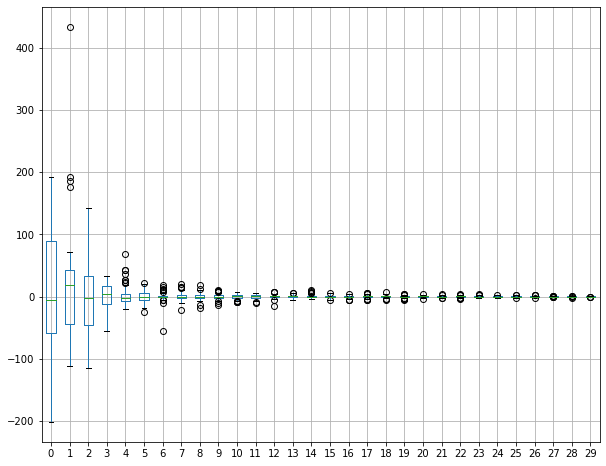

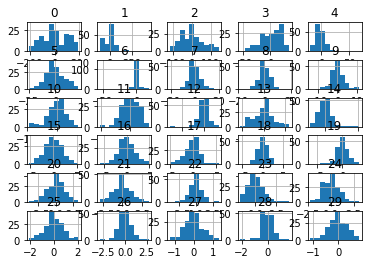

In [24]:
plt.figure(figsize=(10,8))
X.boxplot()
X.hist()
df.describe()

In [25]:
skewness = df.skew()
print(skewness)

Unnamed: 0   -0.361835
0             0.009842
1             1.272854
2             0.408304
3            -0.553588
4             2.358456
5             0.262781
6            -5.635667
7             0.348291
8             0.048778
9            -0.118507
10           -0.480534
11           -0.459593
12           -1.350822
13            0.017725
14            1.267799
15            0.023271
16           -0.112908
17           -0.025797
18            0.049919
19           -0.702592
20           -0.097343
21            0.144393
22           -0.265555
23            0.782396
24            0.192550
25            0.093233
26            0.211428
27            0.081003
28           -0.114840
29           -0.251496
dtype: float64


C:\Users\Peter\AppData\Local\Temp\ipykernel_17932\1187460672.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  skewness = df.skew()


### PCA and stuff

In [26]:
dups = df.pivot_table(index = ['Species'], aggfunc ='size')
  
# displaying the duplicate Series
sorted_species = (dups.sort_values(ascending=False))[:6]

print(sorted_species.keys())

'''keep only rows containing the top 5 species'''
df = df[df['Species'].isin(sorted_species.keys())]
X = df[features]

Index(['lar', 'cristata', 'mitis', 'badius', 'polykomos', 'torquatus'], dtype='object', name='Species')


In [27]:
pca = PCA(n_components=2)
components = pca.fit_transform(X)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter(components, x=0, y=1, color=df['Species'])

for i, feature in enumerate(X.columns):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.show()

In [28]:
pca = PCA(n_components=3)
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=df['Species'],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
)
fig.show()

In [29]:
n_components = 4

pca = PCA(n_components=n_components)
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum() * 100

labels = {str(i): f"PC {i+1}" for i in range(n_components)}
labels['color'] = 'Species'

fig = px.scatter_matrix(
    components,
    color=df.Species,
    dimensions=range(n_components),
    labels=labels,
    title=f'Total Explained Variance: {total_var:.2f}%',
)
fig.update_traces(diagonal_visible=False)
fig.show()